This notebook contains the Healthy and Faulty audios prediction. We've worked with Librosa methods to extract the MFCC Features. Then we've predicted the audios with SVM.

## Importing libraries

In [1]:
import glob
import pandas as pd 
import math
import secrets
from sklearn.model_selection import train_test_split
import numpy as np
import librosa
import librosa.display
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from sklearn.svm import SVC
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Creating an ID generator for the test set

In [2]:
def random_alphanum(length: int) -> str:
        text = secrets.token_hex(nbytes=math.ceil(length / 2))
        isEven = length % 2 == 0
        return text if isEven else text[1:]

## Creating a training set

In [3]:
# assign directory
directory = '.\Data'
 
# iterate over files in
# that directory
dataset_dict = {
    'relative_path' : [],
    'classID' : [],
    'id_file' : []
}
sum1 = 0
relative_path = []
classID = []
id_file = []
for filename in glob.iglob(f'{directory}/*.wav'):
    relative_path.append(filename)
    if ("Faulty" in filename):
        classID.append(0)
    else:
        classID.append(1)
for i in range(0, len(list(glob.iglob(f'{directory}/*.wav')))):
    id_file.append(random_alphanum(6))
dataset_dict['relative_path'] = relative_path
dataset_dict['classID'] = classID
dataset_dict['id_file'] = id_file

In [4]:
df_dataset = pd.DataFrame(dataset_dict, columns = ['relative_path', 'classID', 'id_file'])

## Showing the Distribution of Healthy and Faulty Sounds

C:\Users\berra\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


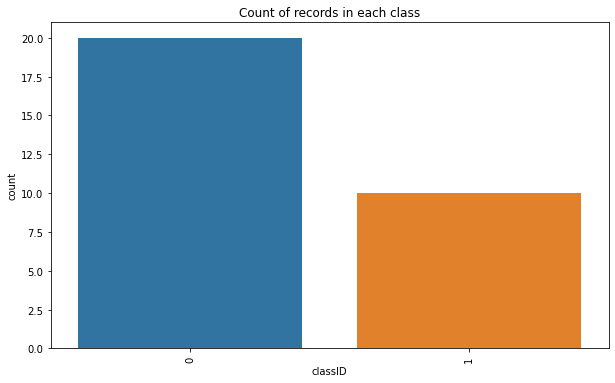

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(df_dataset['classID'])
plt.title("Count of records in each class")
plt.xticks(rotation="vertical")
plt.savefig(".\charts\Count of records in each class.png")
plt.show()

## Features Extraction

In [6]:
def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [7]:
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(df_dataset.iterrows()):
    file_name = os.path.join(os.path.abspath(""),str(row["relative_path"]))
    final_class_labels=row["classID"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

30it [00:07,  4.14it/s]


In [8]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[123.34522, 105.97169, -56.81883, 43.293747, -...",0
1,"[118.700745, 108.6886, -55.97689, 42.479702, -...",0
2,"[115.57558, 107.75453, -53.80512, 41.020267, -...",0
3,"[105.940796, 119.60933, -52.67761, 43.58293, -...",0
4,"[61.87373, 125.43388, -4.3916683, 44.954285, -...",0


## Generating the training and in-sample test sets

In [9]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
# y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [10]:
np.save(r'.\Data\Dataset\X_train',X_train,allow_pickle =False)
np.save(r'.\Data\Dataset\X_test',X_test,allow_pickle =False)
np.save(r'.\Data\Dataset\y_train',y_train,allow_pickle =False)
np.save(r'.\Data\Dataset\y_test',y_test,allow_pickle =False)

In [11]:
X_train = np.load(r'.\Data\Dataset\X_train.npy')
X_test = np.load(r'.\Data\Dataset\X_test.npy')
y_train = np.load(r'.\Data\Dataset\y_train.npy')
y_test = np.load(r'.\Data\Dataset\y_test.npy')

## Training the SVM (Support Vector Machines) model

In [12]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

SVC(kernel='linear')

In [13]:
filename = '.\Pickle\SVM-model-Healthy-Faulty-Audios.pkl'
pickle.dump(svclassifier,  open(filename, 'wb'))

In [14]:
saved_svclassifier = pickle.load(open(filename, 'rb'))

In [15]:
y_pred = saved_svclassifier.predict(X_test)

In [16]:
y_test

array([0, 1, 0, 0, 1, 1])

## Showing scores

In [17]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[3 0]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [18]:
# assign directory
directory = '.\Test'
 
# iterate over files in
# that directory
test_dict = {
    'relative_path' : [],
    'classID' : [],
    'id_file' : []
}
sum1 = 0
relative_path = []
classID = []
id_file = []
for filename in glob.iglob(f'{directory}/*.wav'):
    relative_path.append(filename)
    if ("Faulty" in filename):
        classID.append(0)
    else:
        classID.append(1)
for i in range(0, len(list(glob.iglob(f'{directory}/*')))-1):
    id_file.append(random_alphanum(6))
test_dict['relative_path'] = relative_path
test_dict['classID'] = classID
test_dict['id_file'] = id_file

In [19]:
df_test_dataset = pd.DataFrame(test_dict, columns = ['relative_path', 'classID', 'id_file'])

## Generating the results

In [20]:
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features_pred=[]
for index_num,row in tqdm(df_test_dataset.iterrows()):
    file_name = os.path.join(os.path.abspath(""),str(row["relative_path"]))
    final_class_labels=row["classID"]
    relative_path=row["relative_path"]
    id_file=row["id_file"]
    data=features_extractor(file_name)
    extracted_features_pred.append([data,final_class_labels, relative_path, id_file])

10it [00:02,  4.39it/s]


In [21]:
### converting extracted_features to Pandas dataframe
pred_extracted_features_df=pd.DataFrame(extracted_features_pred,columns=['feature','class', 'relative_path', 'id_file'])
pred_extracted_features_df.head()

,feature,class,relative_path,id_file
0,"[118.99102, 106.128716, -51.756153, 47.227947,...",0,.\Test\FaultyM1S1.wav,660fb7
1,"[49.868435, 129.25395, -25.641544, 51.80968, 2...",0,.\Test\FaultyM2S4.wav,d5075b
2,"[-8.746373, 125.574135, -28.501804, 49.920425,...",0,.\Test\FaultyM4S1.wav,cc26ec
3,"[1.2622161, 140.49648, -25.142649, 50.490265, ...",0,.\Test\FaultyM5S4.wav,102307
4,"[3.042815, 140.26788, -25.14304, 48.45671, -4....",0,.\Test\FaultyM5S5.wav,fd0d71


In [22]:
X_pred=np.array(pred_extracted_features_df['feature'].tolist())

In [23]:
y_real_pred=np.array(pred_extracted_features_df['class'].tolist())

In [24]:
y_pred_test = saved_svclassifier.predict(X_pred)

In [25]:
pred_extracted_features_df["Predicted_Class"] = y_pred_test

In [26]:
pred_extracted_features_df = pred_extracted_features_df[['id_file', 'relative_path', 'Predicted_Class', 'class']]

In [27]:
pred_extracted_features_df

,id_file,relative_path,Predicted_Class,class
0,660fb7,.\Test\FaultyM1S1.wav,0,0
1,d5075b,.\Test\FaultyM2S4.wav,0,0
2,cc26ec,.\Test\FaultyM4S1.wav,0,0
3,102307,.\Test\FaultyM5S4.wav,0,0
4,fd0d71,.\Test\FaultyM5S5.wav,0,0
5,f154e3,.\Test\HealthyM6S1.wav,1,1
6,1a4ddf,.\Test\HealthyM6S5.wav,1,1
7,e5c720,.\Test\HealthyM7S5.wav,1,1
8,faac32,.\Test\HealthyM8S10.wav,1,1
9,fba452,.\Test\HealthyM8S9.wav,1,1


In [44]:
pred_extracted_features_df.to_csv(r".\results\Results-of-the-Healthy-and-Faulty-sounds-prediction.csv", sep=",", index=False)